<a href="https://colab.research.google.com/github/nv-hiep/ML/blob/main/s3_multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer Perceptron và Backpropagation

# 1. Import libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from IPython.display import Image

from matplotlib import rc
rc('animation', html='jshtml')

%matplotlib inline

# 2. Data

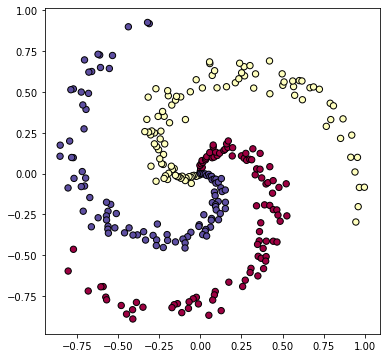

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolors='k', cmap=plt.cm.Spectral)
plt.show()

# 3. Softmax function

## 3.1 Softmax function

$a_i = \frac{e^{x_i}}{\sum_{j=1}^{C} e^{z_j}}$

In [3]:
def softmax(Z):
  """
  Compute softmax values for each sets of scores in V.
  each column of V is a set of score.    
  """
  eZ = np.exp(Z)
  return eZ / eZ.sum(axis=0)

## 3.2 Stable softmax

$\frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}} = \frac{e^{z_i}e^{-C}}{e^{-C}\sum_{j=1}^{C} e^{z_j}} = \frac{e^{(z_i - C)}}{ \sum_{j=1}^{C} e^{(z_j - C)} }$

In [4]:
def softmax_stable(Z):
  """
  Compute softmax values for each sets of scores in Z.
  each column of Z is a set of score.    
  """
  eZ = np.exp( Z - np.max(Z, axis=0, keepdims=True) ) # Max along rows, keepsdims = True to make the subtraction possible
  return eZ / eZ.sum(axis=0)

# 4. Example for MLP

Input layer (d=2) -> Hidden Layer(d=h) -> Output (Softmax Regression) (d=C=3)

Feedforward:

$\mathbf{Z^{(1)} = W^{(1) \it{T}} X}$

ReLU: $\mathbf{A^{(1)} = max(Z^{(1)}, 0)}$

$\mathbf{Z^{(2)} = W^{(2) \it{T}} A^{(1)}}$

$\mathbf{ \hat Y = A^{(2)} = softmax(Z^{(2)})}$

Back Propagation:

$\mathbf{E^{(2)} = \frac{\partial J}{\partial Z^{(2)}} = \frac{1}{N} (\hat Y - Y)}$

$\mathbf{\frac{\partial J}{\partial W^{(2)}} = A^{(1)} E^{(2) \it{T}}}$

$\mathbf{\frac{\partial J}{\partial b^{(2)}} = \sum_{n=1}^{N} e^{(2)}_n }$

$\mathbf{E^{(1)} = (W^{(2)} E^{(2)}) \odot f^{\prime}(Z^{(1)}) }$

$\mathbf{ \frac{\partial J}{\partial W^{(1)} } = A^{(0)} E^{(1) \it{T}}  = X E^{(1) \it{T}}}$

$\mathbf{ \frac{\partial J}{\partial b^{(1)} } = \sum_{n=1}^{N} e^{(1)}_{n} }$

Loss function:

$J = J(\mathbf{W, b; X, Y}) = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{ji}log(\hat y_{ji})$ where C is number of classes

In [5]:
## One-hot coding
from scipy import sparse
def convert_labels(y, C = 3):
  return sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()

# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

## 4.1 Size of hidden layer h = 100

In [6]:
d0 = 2
d1 = h = 100 # Size of hidden layer
d2 = C = 3

# Randomly initialize params
W1 = 0.01 * np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))

W2 = 0.01 * np.random.randn(d1,d2)
b2 = np.zeros((d2, 1))

Y = convert_labels(y, C)

In [7]:
print('Y shape: ', Y.shape)
print(Y[1,:])

Y shape:  (3, 300)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [8]:
print('X shape: ', X.shape)
print('X0, X1: ')
print(X[:10,:])

X shape:  (300, 2)
X0, X1: 
[[ 0.          0.        ]
 [-0.0008755   0.010063  ]
 [ 0.00129638  0.02016038]
 [ 0.00231182  0.03021472]
 [ 0.01169318  0.03867501]
 [-0.00262384  0.05043685]
 [ 0.00523821  0.06037927]
 [ 0.01449592  0.06920519]
 [ 0.01036202  0.08014097]
 [ 0.03194066  0.0851132 ]]


In [9]:
N   = X.shape[0]
eta = 1. # Learning rate

In [10]:
for i in range(10000):
  ## Feedforward
  Z1 = np.dot(W1.T, X.T) + b1
  A1 = np.maximum(Z1, 0)
  Z2 = np.dot(W2.T, A1) + b2
  Yhat = softmax_stable(Z2)

  # print loss after each 1000 iterations
  if i %1000 == 0:
    # compute the loss: average cross-entropy loss
    loss = cost(Y, Yhat)
    print("iter %d, loss: %f" %(i, loss))
  
  # backpropagation
  E2 = (Yhat - Y )/N
  dW2 = np.dot(A1, E2.T)
  db2 = np.sum(E2, axis = 1, keepdims = True)
  E1 = np.dot(W2, E2)
  E1[Z1 <= 0] = 0 # gradient of ReLU
  dW1 = np.dot(X.T, E1.T)
  db1 = np.sum(E1, axis = 1, keepdims = True)

  # Gradient Descent update
  W1 += -eta*dW1
  b1 += -eta*db1
  W2 += -eta*dW2
  b2 += -eta*db2

iter 0, loss: 1.098652
iter 1000, loss: 0.124169
iter 2000, loss: 0.051648
iter 3000, loss: 0.036274
iter 4000, loss: 0.030039
iter 5000, loss: 0.026524
iter 6000, loss: 0.024247
iter 7000, loss: 0.022614
iter 8000, loss: 0.021366
iter 9000, loss: 0.020363


### 4.1.1 Results

In [11]:
Z1 = np.dot(W1.T, X.T) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = (100*np.mean(predicted_class == y))
print('training accuracy: %.2f %%' % acc)

training accuracy: 99.33 %


In [12]:
#Visualize 

xm   = np.arange(-1.5, 1.5, 0.025)
xlen = len(xm)

ym   = np.arange(-1.5, 1.5, 0.025)
ylen = len(ym)

xx, yy = np.meshgrid(xm, ym)

In [13]:
print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)

(1, 14400)


In [14]:
X0 = np.vstack((xx1, yy1))
X0.shape

(2, 14400)

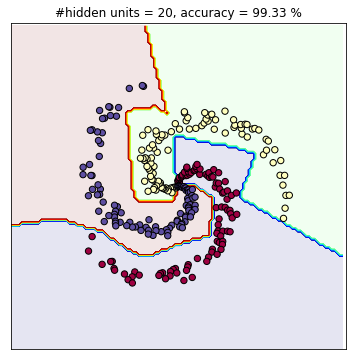

In [36]:
Z1 = np.dot(W1.T, X0) + b1 
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
# predicted class 
Z = np.argmax(Z2, axis=0)

Z = Z.reshape(xx.shape)
N = 100

plt.figure(figsize=(6,6))
CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha = .1)

# plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7)
# plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'g^', markersize = 7)
# plt.plot(X[2*N:, 0], X[2*N:, 1], 'ro', markersize = 7)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolors='k', cmap=plt.cm.Spectral)

# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticks([])
# cur_axes.axes.get_yaxis().set_ticks([])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks(())
plt.yticks(())
plt.title('#hidden units = %d, accuracy = %.2f %%' %(d1, acc))
# plt.axis('equal')
# display(X[1:, :], original_label)
# fn = 'ex_res'+ str(d1) + '.png'
# plt.savefig(fn, bbox_inches='tight', dpi = 600)
plt.show()

## 4.2 Size of hidden layer h = 10

In [16]:
d0 = 2
d1 = h = 10 # Size of hidden layer
d2 = C = 3

# Randomly initialize params
W1 = 0.01 * np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))

W2 = 0.01 * np.random.randn(d1,d2)
b2 = np.zeros((d2, 1))

Y = convert_labels(y, C)

In [17]:
print('Y shape: ', Y.shape)
print(Y[1,:])

Y shape:  (3, 300)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [18]:
print('X shape: ', X.shape)
print('X0, X1: ')
print(X[:10,:])

X shape:  (300, 2)
X0, X1: 
[[ 0.          0.        ]
 [-0.0008755   0.010063  ]
 [ 0.00129638  0.02016038]
 [ 0.00231182  0.03021472]
 [ 0.01169318  0.03867501]
 [-0.00262384  0.05043685]
 [ 0.00523821  0.06037927]
 [ 0.01449592  0.06920519]
 [ 0.01036202  0.08014097]
 [ 0.03194066  0.0851132 ]]


In [19]:
N   = X.shape[0]
eta = 1. # Learning rate

In [20]:
for i in range(10000):
  ## Feedforward
  Z1 = np.dot(W1.T, X.T) + b1
  A1 = np.maximum(Z1, 0)
  Z2 = np.dot(W2.T, A1) + b2
  Yhat = softmax_stable(Z2)

  # print loss after each 1000 iterations
  if i %1000 == 0:
    # compute the loss: average cross-entropy loss
    loss = cost(Y, Yhat)
    print("iter %d, loss: %f" %(i, loss))
  
  # backpropagation
  E2 = (Yhat - Y )/N
  dW2 = np.dot(A1, E2.T)
  db2 = np.sum(E2, axis = 1, keepdims = True)
  E1 = np.dot(W2, E2)
  E1[Z1 <= 0] = 0 # gradient of ReLU
  dW1 = np.dot(X.T, E1.T)
  db1 = np.sum(E1, axis = 1, keepdims = True)

  # Gradient Descent update
  W1 += -eta*dW1
  b1 += -eta*db1
  W2 += -eta*dW2
  b2 += -eta*db2

iter 0, loss: 1.098596
iter 1000, loss: 0.727387
iter 2000, loss: 0.731745
iter 3000, loss: 0.746109
iter 4000, loss: 0.779259
iter 5000, loss: 0.496386
iter 6000, loss: 0.300784
iter 7000, loss: 0.212087
iter 8000, loss: 0.114074
iter 9000, loss: 0.094872


### 4.2.1 Results

In [21]:
Z1 = np.dot(W1.T, X.T) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = (100*np.mean(predicted_class == y))
print('training accuracy: %.2f %%' % acc)

training accuracy: 97.33 %


In [22]:
#Visualize 

xm   = np.arange(-1.5, 1.5, 0.025)
xlen = len(xm)

ym   = np.arange(-1.5, 1.5, 0.025)
ylen = len(ym)

xx, yy = np.meshgrid(xm, ym)

In [23]:
print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)

(1, 14400)


In [24]:
X0 = np.vstack((xx1, yy1))
X0.shape

(2, 14400)

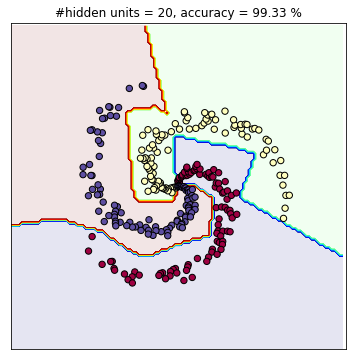

In [37]:
Z1 = np.dot(W1.T, X0) + b1 
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
# predicted class 
Z = np.argmax(Z2, axis=0)

Z = Z.reshape(xx.shape)
N = 100

plt.figure(figsize=(6,6))
CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha = .1)

# plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7)
# plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'g^', markersize = 7)
# plt.plot(X[2*N:, 0], X[2*N:, 1], 'ro', markersize = 7)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolors='k', cmap=plt.cm.Spectral)

# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticks([])
# cur_axes.axes.get_yaxis().set_ticks([])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks(())
plt.yticks(())
plt.title('#hidden units = %d, accuracy = %.2f %%' %(d1, acc))
# plt.axis('equal')
# display(X[1:, :], original_label)
# fn = 'ex_res'+ str(d1) + '.png'
# plt.savefig(fn, bbox_inches='tight', dpi = 600)
plt.show()

## 4.3 Size of hidden layer h = 20

In [26]:
d0 = 2
d1 = h = 20 # Size of hidden layer
d2 = C = 3

# Randomly initialize params
W1 = 0.01 * np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))

W2 = 0.01 * np.random.randn(d1,d2)
b2 = np.zeros((d2, 1))

Y = convert_labels(y, C)

In [27]:
print('Y shape: ', Y.shape)
print(Y[1,:])

Y shape:  (3, 300)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [28]:
print('X shape: ', X.shape)
print('X0, X1: ')
print(X[:10,:])

X shape:  (300, 2)
X0, X1: 
[[ 0.          0.        ]
 [-0.0008755   0.010063  ]
 [ 0.00129638  0.02016038]
 [ 0.00231182  0.03021472]
 [ 0.01169318  0.03867501]
 [-0.00262384  0.05043685]
 [ 0.00523821  0.06037927]
 [ 0.01449592  0.06920519]
 [ 0.01036202  0.08014097]
 [ 0.03194066  0.0851132 ]]


In [29]:
N   = X.shape[0]
eta = 1. # Learning rate

In [30]:
for i in range(10000):
  ## Feedforward
  Z1 = np.dot(W1.T, X.T) + b1
  A1 = np.maximum(Z1, 0)
  Z2 = np.dot(W2.T, A1) + b2
  Yhat = softmax_stable(Z2)

  # print loss after each 1000 iterations
  if i %1000 == 0:
    # compute the loss: average cross-entropy loss
    loss = cost(Y, Yhat)
    print("iter %d, loss: %f" %(i, loss))
  
  # backpropagation
  E2 = (Yhat - Y )/N
  dW2 = np.dot(A1, E2.T)
  db2 = np.sum(E2, axis = 1, keepdims = True)
  E1 = np.dot(W2, E2)
  E1[Z1 <= 0] = 0 # gradient of ReLU
  dW1 = np.dot(X.T, E1.T)
  db1 = np.sum(E1, axis = 1, keepdims = True)

  # Gradient Descent update
  W1 += -eta*dW1
  b1 += -eta*db1
  W2 += -eta*dW2
  b2 += -eta*db2

iter 0, loss: 1.098619
iter 1000, loss: 0.161706
iter 2000, loss: 0.088640
iter 3000, loss: 0.072448
iter 4000, loss: 0.057619
iter 5000, loss: 0.036520
iter 6000, loss: 0.030115
iter 7000, loss: 0.026158
iter 8000, loss: 0.023771
iter 9000, loss: 0.022238


### 4.3.1 Results

In [31]:
Z1 = np.dot(W1.T, X.T) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = (100*np.mean(predicted_class == y))
print('training accuracy: %.2f %%' % acc)

training accuracy: 99.33 %


In [32]:
#Visualize 

xm   = np.arange(-1.5, 1.5, 0.025)
xlen = len(xm)

ym   = np.arange(-1.5, 1.5, 0.025)
ylen = len(ym)

xx, yy = np.meshgrid(xm, ym)

In [33]:
print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)

(1, 14400)


In [34]:
X0 = np.vstack((xx1, yy1))
X0.shape

(2, 14400)

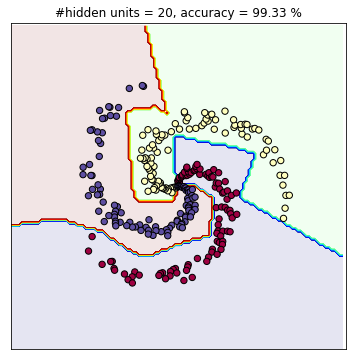

In [38]:
Z1 = np.dot(W1.T, X0) + b1 
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
# predicted class 
Z = np.argmax(Z2, axis=0)

Z = Z.reshape(xx.shape)
N = 100

plt.figure(figsize=(6,6))
CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha = .1)

# plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7)
# plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'g^', markersize = 7)
# plt.plot(X[2*N:, 0], X[2*N:, 1], 'ro', markersize = 7)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolors='k', cmap=plt.cm.Spectral)

# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticks([])
# cur_axes.axes.get_yaxis().set_ticks([])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks(())
plt.yticks(())
plt.title('#hidden units = %d, accuracy = %.2f %%' %(d1, acc))
# plt.axis('equal')
# display(X[1:, :], original_label)
# fn = 'ex_res'+ str(d1) + '.png'
# plt.savefig(fn, bbox_inches='tight', dpi = 600)
plt.show()